# Can money buy baseball wins? Let's try to answer with SQL and Python

The life of a sports fan, while exciting, can also be frustrating: being outside of the action, you're often left to guesses and suppositions as to understand why your team is doing good, or bad... Among all the factors that can have an influence on the amount of wins a team can get throughout a season, the budget is one that often comes to the table: "if we had a bigger budget, we could by better players, and win more!" But, is that true? This is what we'll try to answer here.

To achieve this, we'll use the [Lahman's Baseball Database](http://www.seanlahman.com/baseball-archive/statistics/) that we have stored in a PostgreSQL database using PgAdmin (more info on the data source and database in the [readme](https://github.com/Nicolas-Schonau/SQL-and-the-Major-League-Baseball/blob/master/README.md) file). We'll focus on two main variables : the salaries of players for the 2016 season (as this the most recent data available) and the number of wins per team for this season. 

We'll begin by using SQL to get the needed data from the database, and then will use Python to visualise data and see if there is a correlation between the payroll and the number of wins.

## SQL query

First, we need to query our tables to get the amount payed by each team in salaries, plus the number of wins they got.

So let's begin with our SQL query, which is actually a straightforward one if we take the time to break it down:
- We have two tables, ```salaries```, which contains the salaries for all player until 2016, and ```teams```, which contains all results for each team per year
- Both tables contain the teamid column, which will be used as a key to join them
- Let's start by querying the teamid and the sum of salaries for each player from the ```salaries``` table, and the number of wins per team from the  ```teams``` table
- Then let's join them on the teamid value
- We use a ```WHERE``` clause to ensure that we link the informations for the same years in both tables (we want the salaries of year x to be linked with the wins of season x), and filter on the 2016 season (as this is the most recent data available)
- Optionnaly, if we want to analyse the table directly, we could order the values with the ```ORDER BY``` clause

```sql
SELECT sa.teamid, SUM(sa.salary) as payroll, te.w as wins
FROM salaries sa
INNER JOIN teams te on sa.teamid = te.teamid
WHERE sa.yearid = te.yearid AND sa.yearid = 2016
GROUP BY sa.teamid, te.w
ORDER BY payroll
;
```

Ran in PgAdmin, this query would return a table with the 3 columns ```teamid```, ```payroll``` and ```wins```, and the results for all 30 teams of the league. But for this exercice we are not going to run it in PgAdmin, we'll keep this query for later and first switch to Python.

## Python

First, we need to import the different librairies we are gonna use for this analysis. 
We'll need 3 different ones:
- [psycopg2](https://pypi.org/project/psycopg2/) for the link with the PostgreSQL database
- [pandas](https://pandas.pydata.org/) for the dataframe and the correlation method
- [seaborn](https://seaborn.pydata.org/) in order to add a visualisation of our data

Let's import them:

In [6]:
import psycopg2 as pg2
import pandas as pd
import seaborn as sns

Now, we have to make a connection to the database. Therefore, we use the connect function and set the correct values for the following parameters:
- database : pass the name of the database where the data is stored
- user : per default, PostgreSQL sets it to 'postgres'
- password : insert the password you use to connect to PostgreSQL/PgAdmin

We'll store all parameters inside the "conn" variable:

In [8]:
conn = pg2.connect(database='database_name', user='user_name', password="user_password")

Next, we're going to create a "sql" variable and pass the SQL query we wrote earlier as a string so that we'll be able to execute it afterwards:

In [9]:
sql = "SELECT sa.teamid, SUM(sa.salary) as payroll, te.w as wins FROM salaries sa INNER JOIN teams te on sa.teamid = te.teamid WHERE sa.yearid = te.yearid AND sa.yearid = 2016 GROUP BY sa.teamid, te.w ORDER BY payroll;"

Finally, let's run our query and import its output inside a 'dat' variable, and set it as a pandas dataframe:

In [10]:
dat = pd.read_sql_query(sql, conn)
conn = None
df = pd.DataFrame(data=dat)

And now we're set! Let's start with a visual representation in order to have a first grasp of our results by calling the lmplot() function:

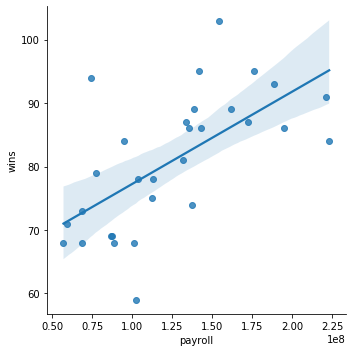

In [17]:
plot = sns.lmplot(x="payroll", y="wins", data=df)

Though there is some dispersion of the data, we can clearly see a positive trend linking the two variables. In order to quantify this correlation, we'll use the pearson correlation by calling the corr() function with the pearson method: 

In [12]:
df.corr(method ='pearson') 

,payroll,wins
payroll,1.000000,0.636288
wins,0.636288,1.000000


And there it is! We now have our matrix telling us that there's a strong positive correlation (r=0.64) between wins and payroll, which means that indeed, the more a team pays in salary (and thus, invests in the quality of its players), the more she'll win. 

Nevertheless, even though we can positively say that there is a link between salaries spendings and wins, we cannot derive from this analysis that more wins are due to higher salaries spendings ("correlation does not imply causation"). Plus, as we see, this is not a "perfect correlation", meaning that even though both variables are linked, more salaries spending is not sufficient to garantee more wins : some teams at the right-end of the plot have less wins than the trend, while some have higher wins with lesser spendings. 

Let this be a message of encouragement for small-market teams with reduced budget!